In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
import tensorflow as tf
from pickle import dump
%matplotlib inline

In [2]:
df = pd.read_json('content/btc_ohlc_daily.json')
df.rename_axis('time', axis=0)
target_col = 'close'

df.head()

,high,low,open,volumefrom,volumeto,close
2010-07-17,0.04951,0.04951,0.04951,20.00,0.9902,0.04951
2010-07-18,0.08585,0.05941,0.04951,75.01,5.0920,0.08584
2010-07-19,0.09307,0.07723,0.08584,574.00,49.6600,0.08080
2010-07-20,0.08181,0.07426,0.08080,262.00,20.5900,0.07474
2010-07-21,0.07921,0.06634,0.07474,575.00,42.2600,0.07921


In [3]:
# Splits and shuffles the dataset into train, validation and test sets.

def train_val_test_split(df, valid_percent=0.1, test_percent=0.05):
    split_idx_1 = int((1-valid_percent-test_percent)*len(df))
    split_idx_2 = int(split_idx_1 + len(df)*valid_percent)
    return np.split(df, [split_idx_1, split_idx_2]) 

train_df, validation_df, test_df = train_val_test_split(df)

In [4]:
print('train:', train_df.shape)
print('validation:', validation_df.shape)
print('test:', test_df.shape)

train: (3327, 6)
validation: (391, 6)
test: (197, 6)


In [5]:
# Normalize values between 0-1 for every feature (each column is divided by column max value).

scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler.fit(train_df)
scaler.fit(df)

train_scaled = scaler.transform(train_df)
validation_scaled = scaler.transform(validation_df)
test_scaled = scaler.transform(test_df)

train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns,index=train_df.index)
validation_scaled_df = pd.DataFrame(validation_scaled, columns=validation_df.columns,index=validation_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns,index=test_df.index)

train_scaled_df.head()

,high,low,open,volumefrom,volumeto,close
2010-07-17,0.000000e+00,6.698774e-07,0.000000e+00,0.000035,1.222345e-10,0.000000e+00
2010-07-18,5.885106e-07,8.377283e-07,0.000000e+00,0.000131,6.285784e-10,5.938240e-07
2010-07-19,7.054354e-07,1.139860e-06,5.938240e-07,0.001003,6.130244e-09,5.114438e-07
2010-07-20,5.230845e-07,1.089505e-06,5.114438e-07,0.000458,2.541718e-09,4.123914e-07
2010-07-21,4.809787e-07,9.552238e-07,4.123914e-07,0.001005,5.216756e-09,4.854548e-07


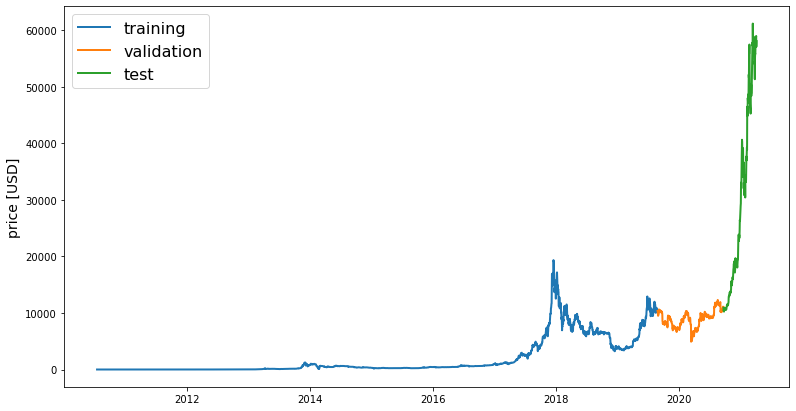

In [6]:
def line_plot(line1, line2, line3, label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    
line_plot(train_df[target_col], validation_df[target_col], test_df[target_col], 'training', 'validation', 'test', title='')

In [7]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10):
    x = extract_window_data(df, window_len)
    y = df[target_col][window_len:].values
    return x, y

def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape =(input_data.shape[1],input_data.shape[2])))
    #model.add(LSTM(neurons, return_sequences=True, input_shape =(input_data.shape[1],input_data.shape[2])))
    #model.add(Dropout(dropout))
    #model.add(LSTM(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [8]:
np.random.seed(42)
window_len = 10
lstm_neurons = 100
epochs = 200
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [9]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
#mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [10]:
#X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_scaled, target_col, window_len=window_len)

X_train, y_train = prepare_data(train_scaled_df, target_col, window_len=window_len)
X_val, y_val = prepare_data(validation_scaled_df, target_col, window_len=window_len)
X_test, y_test = prepare_data(test_scaled_df, target_col, window_len=window_len)

In [11]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False, callbacks=[es, mc])

Epoch 1/200
104/104 [==============================] - ETA: 0s - loss: 2.6554e-04
Epoch 00001: val_loss improved from inf to 0.00021, saving model to best_model.h5
104/104 [==============================] - 1s 12ms/step - loss: 2.6554e-04 - val_loss: 2.1289e-04
Epoch 2/200
 96/104 [==========================>...] - ETA: 0s - loss: 2.0778e-04
Epoch 00002: val_loss improved from 0.00021 to 0.00006, saving model to best_model.h5
104/104 [==============================] - 1s 6ms/step - loss: 2.0589e-04 - val_loss: 6.3775e-05
Epoch 3/200
 96/104 [==========================>...] - ETA: 0s - loss: 7.5244e-05
Epoch 00003: val_loss did not improve from 0.00006
104/104 [==============================] - 1s 6ms/step - loss: 9.4040e-05 - val_loss: 7.0332e-05
Epoch 4/200
102/104 [============================>.] - ETA: 0s - loss: 1.6120e-04
Epoch 00004: val_loss improved from 0.00006 to 0.00006, saving model to best_model.h5
104/104 [==============================] - 1s 8ms/step - loss: 1.6377e-04 -

In [12]:
# load the best modell
model = load_model('best_model.h5')

# evaluate the model
train_acc = model.evaluate(X_train, y_train, verbose=0)
test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.000, Test: 0.005


In [13]:
X_test.shape

(187, 10, 6)

In [14]:
preds = model.predict(X_test).squeeze()

arr = np.zeros([preds.shape[0], 6])
arr[:, 5] = preds

res = scaler.inverse_transform(arr)

df_res = pd.DataFrame(res, columns=df.columns)

df_res.head()

,high,low,open,volumefrom,volumeto,close
0,0.04951,0.01,0.04951,0.0,0.0,10728.254039
1,0.04951,0.01,0.04951,0.0,0.0,10746.592774
2,0.04951,0.01,0.04951,0.0,0.0,10687.123164
3,0.04951,0.01,0.04951,0.0,0.0,10591.334362
4,0.04951,0.01,0.04951,0.0,0.0,10562.413203


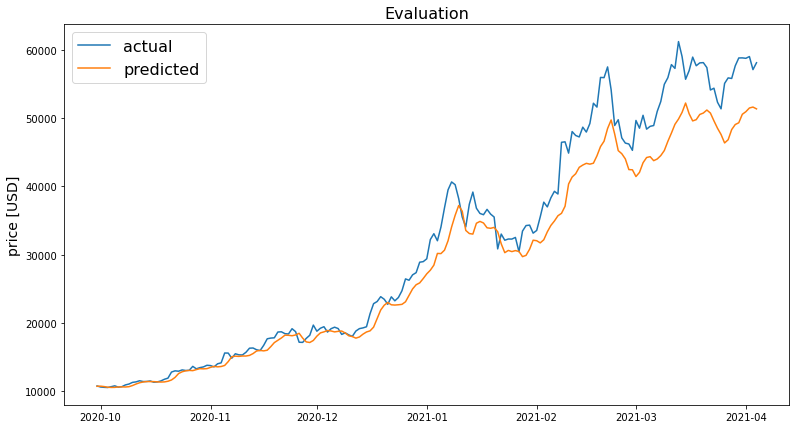

In [15]:
predicted_closing_prices = df_res[target_col].values
actual_closing_prices = test_df[target_col][window_len:]
predicted_closing_prices = pd.Series(index=actual_closing_prices.index, data=predicted_closing_prices)

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(actual_closing_prices, label='actual')
ax.plot(predicted_closing_prices, label='predicted')
ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title('Evaluation', fontsize=16)
ax.legend(loc='best', fontsize=16)
plt.show()

In [16]:
res_data = {'time': test_df.index[window_len:], 'actual': test_df[target_col][window_len:], 'preds' :predicted_closing_prices}
res_df = pd.DataFrame(data=res_data)
res_df = res_df.set_index('time')

In [17]:
res_df.head()

,actual,preds
time,,
2020-09-30,10779.42,10728.254039
2020-10-01,10622.79,10746.592774
2020-10-02,10576.64,10687.123164
2020-10-03,10552.04,10591.334362
2020-10-04,10675.52,10562.413203


In [18]:
res_df.to_json(r'results.json')

In [19]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [20]:
for layer in model.layers:
    print(layer)

In [21]:
for layer in model.layers:
    print('input', layer.input_shape)
    print('output', layer.output_shape)

input (None, 10, 6)
output (None, 100)
input (None, 100)
output (None, 100)
input (None, 100)
output (None, 1)
input (None, 1)
output (None, 1)


In [22]:
# save the scaler
dump(scaler, open('scaler.pkl', 'wb'))